<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_19_Mindlin_plate_in_free_vibrations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Natural frequency parameter D (20x20 Q4, CCCC, h/a=0.1, k=0.8601, nu=0.3)
 1: 1.5996
 2: 3.0784
 3: 3.0784
 4: 4.3129
 5: 5.1513
 6: 5.2011
 7: 6.1950
 8: 6.1950
 9: 7.7076
10: 7.7076
11: 7.8218
12: 8.5153
13: 8.5982


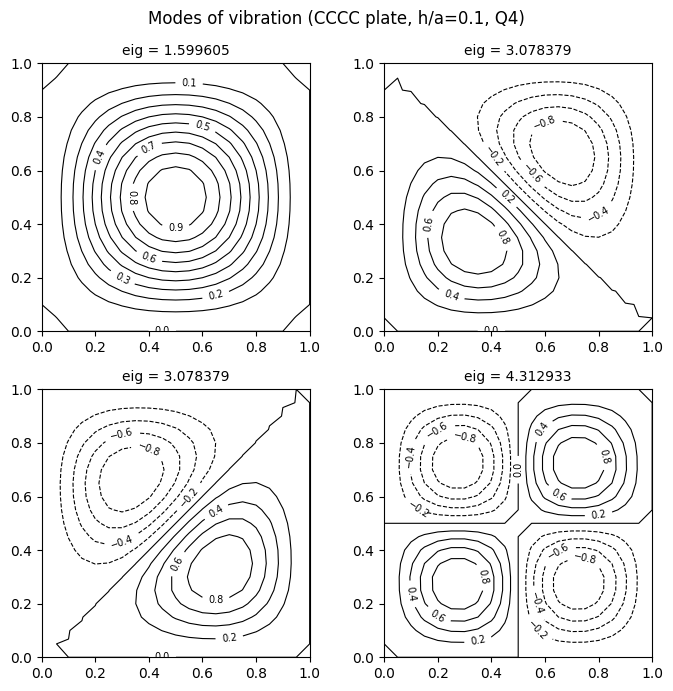

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# ============================================================
# Q4 utilities
# ============================================================
def gaussQuadrature(option='complete'):
    if option == 'complete':  # 2x2
        a = 0.577350269189626
        locations = np.array([[-a, -a],
                              [ a, -a],
                              [ a,  a],
                              [-a,  a]], dtype=float)
        weights = np.array([1, 1, 1, 1], dtype=float)
    elif option == 'reduced':  # 1x1
        locations = np.array([[0.0, 0.0]], dtype=float)
        weights = np.array([4.0], dtype=float)
    else:
        raise ValueError("option must be 'complete' or 'reduced'")
    return weights, locations


def shapeFunctionQ4(xi, eta):
    N = 0.25 * np.array([
        (1-xi)*(1-eta),
        (1+xi)*(1-eta),
        (1+xi)*(1+eta),
        (1-xi)*(1+eta)
    ], dtype=float)

    dN = 0.25 * np.array([
        [-(1-eta), -(1-xi)],
        [ (1-eta), -(1+xi)],
        [ (1+eta),  (1+xi)],
        [-(1+eta),  (1-xi)]
    ], dtype=float)  # cols: d/dxi, d/deta
    return N, dN


def Jacobian(nodeCoords_elem, naturalDerivatives):
    J = nodeCoords_elem.T @ naturalDerivatives
    invJ = np.linalg.inv(J)
    XYder = naturalDerivatives @ invJ
    return J, invJ, XYder


def rectangularMesh(Lx, Ly, nEx, nEy, centered=False):
    """
    centered=False: domain [0,Lx]x[0,Ly]
    centered=True : domain [-Lx,Lx]x[-Ly,Ly]
    """
    if centered:
        xs = np.linspace(-Lx, Lx, nEx + 1)
        ys = np.linspace(-Ly, Ly, nEy + 1)
    else:
        xs = np.linspace(0.0, Lx, nEx + 1)
        ys = np.linspace(0.0, Ly, nEy + 1)

    X, Y = np.meshgrid(xs, ys)
    nodeCoordinates = np.column_stack([X.ravel(), Y.ravel()])

    def nid(ix, iy):
        return iy*(nEx+1) + ix + 1  # 1-based

    elems = []
    for iy in range(nEy):
        for ix in range(nEx):
            n1 = nid(ix,   iy)
            n2 = nid(ix+1, iy)
            n3 = nid(ix+1, iy+1)
            n4 = nid(ix,   iy+1)
            elems.append([n1, n2, n3, n4])

    return nodeCoordinates, np.array(elems, dtype=int)


# ============================================================
# EssentialBC
# DOF order: w(1..N), tx(N+1..2N), ty(2N+1..3N)
# ============================================================
def EssentialBC(typeBC, GDoF, xx, yy, nodeCoordinates, numberNodes):
    xmin, xmax = np.min(nodeCoordinates[:, 0]), np.max(nodeCoordinates[:, 0])
    ymin, ymax = np.min(nodeCoordinates[:, 1]), np.max(nodeCoordinates[:, 1])

    on_left   = np.where(np.isclose(xx, xmin))[0] + 1
    on_right  = np.where(np.isclose(xx, xmax))[0] + 1
    on_bottom = np.where(np.isclose(yy, ymin))[0] + 1
    on_top    = np.where(np.isclose(yy, ymax))[0] + 1

    edges_all = np.unique(np.hstack([on_left, on_right, on_bottom, on_top]))
    bc = typeBC.lower()

    if bc == 'ssss':
        fixedNodeW  = edges_all
        fixedNodeTX = np.unique(np.hstack([on_top, on_bottom]))
        fixedNodeTY = np.unique(np.hstack([on_left, on_right]))

    elif bc == 'cccc':
        fixedNodeW  = edges_all
        fixedNodeTX = fixedNodeW
        fixedNodeTY = fixedNodeTX

    elif bc == 'cccf':
        fixedNodeW  = np.unique(np.hstack([on_left, on_bottom, on_top]))
        fixedNodeTX = fixedNodeW
        fixedNodeTY = fixedNodeTX

    elif bc == 'scsc':
        fixedNodeW  = edges_all
        fixedNodeTX = np.unique(np.hstack([on_top, on_bottom]))
        fixedNodeTY = np.array([1], dtype=int)  # tiny constraint to avoid rigid mode

    else:
        raise ValueError("typeBC must be one of: 'ssss','cccc','cccf','scsc'")

    prescribedDof = np.unique(np.hstack([
        fixedNodeW,
        fixedNodeTX + numberNodes,
        fixedNodeTY + 2*numberNodes
    ])).astype(int)

    allDof = np.arange(1, GDoF + 1, dtype=int)
    activeDof = np.setdiff1d(allDof, prescribedDof)

    return prescribedDof, activeDof, fixedNodeW


# ============================================================
# Mindlin plate stiffness K
# ============================================================
def formStiffnessMatrixMindlinQ4(GDoF, numberElements, elementNodes, numberNodes,
                                 nodeCoordinates, C_shear, C_bending):
    K = np.zeros((GDoF, GDoF), dtype=float)

    # bending: complete 2x2
    gw_b, gl_b = gaussQuadrature('complete')
    for e in range(numberElements):
        indice = elementNodes[e, :]
        nodes = indice.astype(int) - 1
        ndof = len(indice)

        elementDof = np.hstack([indice, indice + numberNodes, indice + 2*numberNodes]).astype(int) - 1

        for q in range(len(gw_b)):
            xi, eta = gl_b[q, 0], gl_b[q, 1]
            wt = gw_b[q]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, dN_xy = Jacobian(nodeCoordinates[nodes, :], dN_nat)
            detJ = np.linalg.det(J)

            B_b = np.zeros((3, 3*ndof), dtype=float)
            B_b[0, ndof:2*ndof]       = dN_xy[:, 0]  # d(tx)/dx
            B_b[1, 2*ndof:3*ndof]     = dN_xy[:, 1]  # d(ty)/dy
            B_b[2, ndof:2*ndof]       = dN_xy[:, 1]  # d(tx)/dy
            B_b[2, 2*ndof:3*ndof]     = dN_xy[:, 0]  # d(ty)/dx

            K[np.ix_(elementDof, elementDof)] += (B_b.T @ C_bending @ B_b) * wt * detJ

    # shear: reduced 1x1
    gw_s, gl_s = gaussQuadrature('reduced')
    for e in range(numberElements):
        indice = elementNodes[e, :]
        nodes = indice.astype(int) - 1
        ndof = len(indice)

        elementDof = np.hstack([indice, indice + numberNodes, indice + 2*numberNodes]).astype(int) - 1

        for q in range(len(gw_s)):
            xi, eta = gl_s[q, 0], gl_s[q, 1]
            wt = gw_s[q]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, dN_xy = Jacobian(nodeCoordinates[nodes, :], dN_nat)
            detJ = np.linalg.det(J)

            B_s = np.zeros((2, 3*ndof), dtype=float)
            # gamma_xz = dw/dx + tx
            B_s[0, 0:ndof]          = dN_xy[:, 0]
            B_s[0, ndof:2*ndof]     = N
            # gamma_yz = dw/dy + ty
            B_s[1, 0:ndof]          = dN_xy[:, 1]
            B_s[1, 2*ndof:3*ndof]   = N

            K[np.ix_(elementDof, elementDof)] += (B_s.T @ C_shear @ B_s) * wt * detJ

    return K


# ============================================================
# Mindlin plate mass matrix M
# ============================================================
def formMassMatrixMindlinQ4(GDoF, numberElements, elementNodes, numberNodes,
                            nodeCoordinates, thickness, rho, I):
    M = np.zeros((GDoF, GDoF), dtype=float)
    gw, gl = gaussQuadrature('complete')

    for e in range(numberElements):
        indice = elementNodes[e, :]
        nodes = indice.astype(int) - 1

        for q in range(len(gw)):
            xi, eta = gl[q, 0], gl[q, 1]
            wt = gw[q]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, dN_xy = Jacobian(nodeCoordinates[nodes, :], dN_nat)
            detJ = np.linalg.det(J)

            NN = np.outer(N, N) * wt * detJ

            # w-w block
            M[np.ix_(nodes, nodes)] += NN * (thickness * rho)

            # tx-tx block
            tx = nodes + numberNodes
            M[np.ix_(tx, tx)] += NN * (I * rho)

            # ty-ty block
            ty = nodes + 2*numberNodes
            M[np.ix_(ty, ty)] += NN * (I * rho)

    return M


# ============================================================
# Modes contour (no logic change)
# ============================================================
def plot_modes_contour(x, y, W, eigvals, modes=(0, 1, 2, 3), levels=10):
    fig, axes = plt.subplots(2, 2, figsize=(7, 7))
    axes = axes.flatten()

    Nx = len(np.unique(x))
    Ny = len(np.unique(y))
    X = x.reshape(Ny, Nx)
    Y = y.reshape(Ny, Nx)

    for i, m in enumerate(modes):
        ax = axes[i]
        w = W[:, m].reshape(Ny, Nx)
        w = w / np.max(np.abs(w))

        cs = ax.contour(X, Y, w, levels=levels, colors='black', linewidths=0.8)
        ax.clabel(cs, inline=True, fontsize=7)

        ax.set_aspect('equal')
        ax.set_xlim(X.min(), X.max())
        ax.set_ylim(Y.min(), Y.max())
        ax.set_title(f"eig = {eigvals[m]:.6f}", fontsize=10)

    plt.suptitle("Modes of vibration (CCCC plate, h/a=0.1, Q4)", fontsize=12)
    plt.tight_layout()
    plt.show()


# ============================================================
# MAIN
# ============================================================
def main():
    nu = 0.30
    kappa = 0.8601
    a = 1.0
    h = 0.1
    rho = 1.0
    E = 10920.0

    I = h**3 / 12.0

    C_bending = (I * E / (1 - nu**2)) * np.array([
        [1,   nu, 0],
        [nu,  1,  0],
        [0,   0,  (1 - nu)/2]
    ], dtype=float)

    C_shear = (kappa * h * E / (2.0 * (1 + nu))) * np.eye(2)

    nEx = 20
    nEy = 20
    nodeCoordinates, elementNodes = rectangularMesh(a, a, nEx, nEy, centered=False)
    xx = nodeCoordinates[:, 0]
    yy = nodeCoordinates[:, 1]
    numberNodes = nodeCoordinates.shape[0]
    numberElements = nEx * nEy
    GDoF = 3 * numberNodes

    K = formStiffnessMatrixMindlinQ4(GDoF, numberElements, elementNodes, numberNodes,
                                     nodeCoordinates, C_shear, C_bending)
    M = formMassMatrixMindlinQ4(GDoF, numberElements, elementNodes, numberNodes,
                                nodeCoordinates, h, rho, I)

    prescribedDof, activeDof, fixedNodeW = EssentialBC('cccc', GDoF, xx, yy, nodeCoordinates, numberNodes)

    active0 = activeDof - 1
    Kaa = K[np.ix_(active0, active0)]
    Maa = M[np.ix_(active0, active0)]

    eigvals, eigvecs = eigh(Kaa, Maa)
    eigvals = np.maximum(eigvals, 0.0)

    # normalization (same logic)
    G = E / 2.6
    omega = np.sqrt(eigvals)
    D = omega * a * np.sqrt(rho / G)

    # sort
    sort_idx = np.argsort(D)
    D = D[sort_idx]
    omega = omega[sort_idx]
    eigvecs = eigvecs[:, sort_idx]   # sort eigenvectors the same way

    numberOfModes = 12

    print("Natural frequency parameter D (20x20 Q4, CCCC, h/a=0.1, k=0.8601, nu=0.3)")
    for i in range(13):
        print(f"{i+1:2d}: {D[i]:.4f}")

    # --- build Wmodes (w-only) ---
    activeDofW = np.setdiff1d(np.arange(1, numberNodes+1), fixedNodeW)
    NNN = len(activeDofW)

    Wmodes = np.zeros((numberNodes, numberOfModes))
    Vsorted = eigvecs  # already sorted above

    for i in range(numberOfModes):
        Wmodes[activeDofW - 1, i] = Vsorted[:NNN, i]

    # plot 4 modes like book figure
    plot_modes_contour(xx, yy, Wmodes, D, modes=(0, 1, 2, 3), levels=10)


if __name__ == "__main__":
    main()
